<center>
<img src="https://i.vas3k.blog/7sc.jpg" height="400">

# Семинар 2: Копаем в картинки, учим сетки!
</center>

Сегодня знакомство с понятием картинки и основными операциями для работы с изображениями.

### План семинара

1. Учимся работать с картинками средствами **Python**, **OpenCV**, **NumPy** и **PyTorch**
2. Применяем константные свёртки к изображениям. Обучаем свёрточные сетки
3. Изучаем transfer learning и современные подходы к обучению (включая архитектуры)


In [142]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

# 1. Разбираемся что такое картинка с помощью OpenCV

OpenCV (Open Source Computer Vision Library) — это мощная библиотека с открытым исходным кодом для компьютерного зрения и обработки изображений. Разработана Intel в 1999 году и содержит более 2500 оптимизированных алгоритмов для работы с изображениями и видео.


OpenCV включает классические алгоритмы для:
  - детектирования границ и контуров
  - морфологических операций
  - фильтрации и обработки изображений
  - детектирования объектов (лица, глаза, etc.)
  - работы с видео и камерами

В отличие от PyTorch, где мы работаем с тензорами и нейросетями, OpenCV предоставляет готовые классические алгоритмы компьютерного зрения, которые работают быстро и не требуют обучения.



In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Матричное представление изображения

На самом деле каждая картинка это набор пикселей. Если мы попросим питон показать нам картинку, он покажет матрицу из чисел.  Каждому пикселю в этой матрице соответствует число. Это число сообщает нам о том, насколько этот пиксель яркий. Яркость можно измерять в разных шкалах. В нашем случае она измеряется по шкале от $0$ до $1$.

Цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему. Такой формат хранения картинки называется [RGB-форматом.](https://www.wikiwand.com/ru/RGB)

In [144]:
# при работе в колабе, скачайте изображение этой командой
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png -O test_image.jpg

--2025-11-25 03:39:34--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 462.73K  --.-KB/s    in 0.06s   

2025-11-25 03:39:34 (7.72 MB/s) - ‘test_image.jpg’ saved [473831/473831]



cv2.imread - BGR shape: (512, 512, 3)
RGB shape: (512, 512, 3)
Grayscale shape: (512, 512)


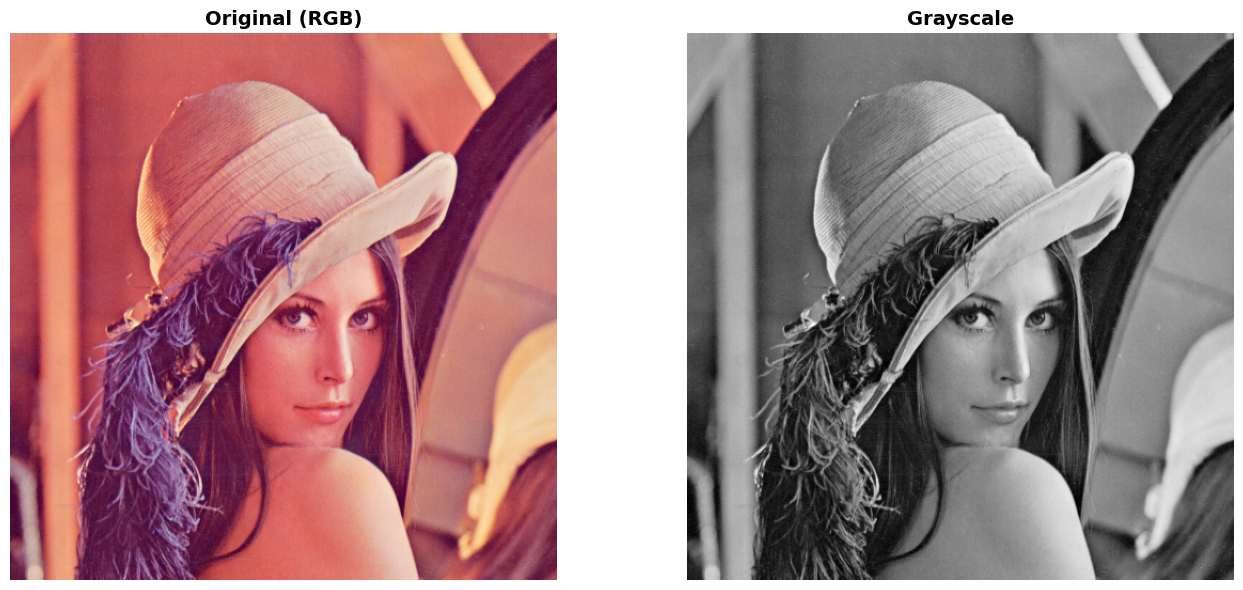

In [145]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Способ 1: Загрузка через cv2.imread (BGR формат)
img_cv = cv2.imread("./test_image.jpg")
print(f"cv2.imread - BGR shape: {img_cv.shape}")

# Конвертируем BGR -> RGB для отображения
img_np = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Создаём grayscale версию
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

print(f"RGB shape: {img_np.shape}")
print(f"Grayscale shape: {gray.shape}")

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Original (RGB)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

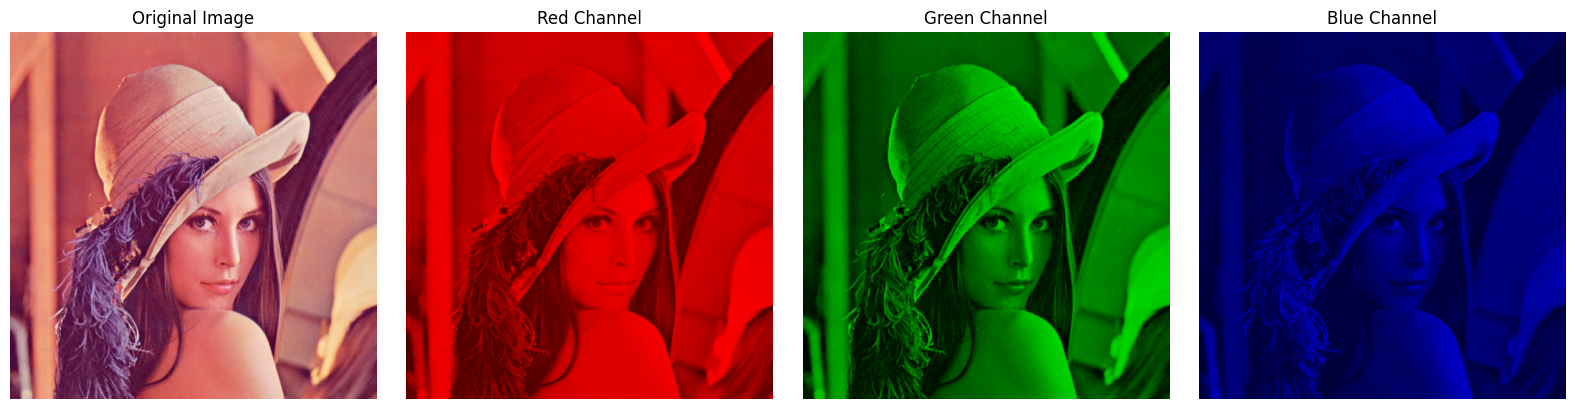

Shape каждого канала: (512, 512)
Диапазон значений для красного канала: [54, 255]


In [146]:
# Разделяем изображение на каналы RGB
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img_rgb)

# Визуализация каналов
plt.figure(figsize=(16, 4))

# Оригинальное изображение
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

# Red channel
plt.subplot(1, 4, 2)
red_img = np.zeros_like(img_rgb)
red_img[:, :, 0] = r
plt.imshow(red_img)
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(1, 4, 3)
green_img = np.zeros_like(img_rgb)
green_img[:, :, 1] = g
plt.imshow(green_img)
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(1, 4, 4)
blue_img = np.zeros_like(img_rgb)
blue_img[:, :, 2] = b
plt.imshow(blue_img)
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Shape каждого канала: {r.shape}")
print(f"Диапазон значений для красного канала: [{r.min()}, {r.max()}]")

##Основные фильтры для детектирования границ


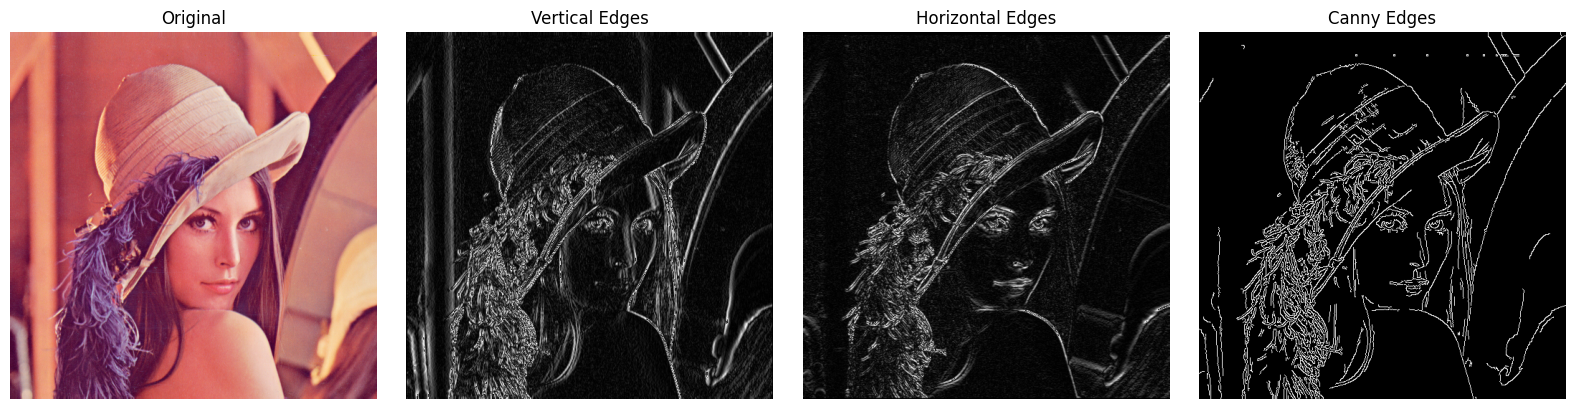

In [147]:
# Вертикальные линии (Sobel)
# cv2.Sobel(image, depth, dx, dy, ksize)
# dx=1, dy=0 - берем производную по x (вертикальные границы)
# ksize=3 - размер ядра свертки 3x3
sobel_vertical = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_vertical = np.uint8(np.absolute(sobel_vertical))

# Горизонтальные линии (Sobel)
# dx=0, dy=1 - берем производную по y (горизонтальные границы)
sobel_horizontal = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_horizontal = np.uint8(np.absolute(sobel_horizontal))

# Canny edge detection
# cv2.Canny(image, threshold1, threshold2)
# 100 - нижний порог, 200 - верхний порог
# Пиксели выше 200 - точно граница, ниже 100 - точно не граница
canny = cv2.Canny(img_cv, 100, 200)

# Визуализация
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(sobel_vertical, cmap='gray')
plt.title('Vertical Edges')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sobel_horizontal, cmap='gray')
plt.title('Horizontal Edges')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(canny, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

## Фильтры с блюром

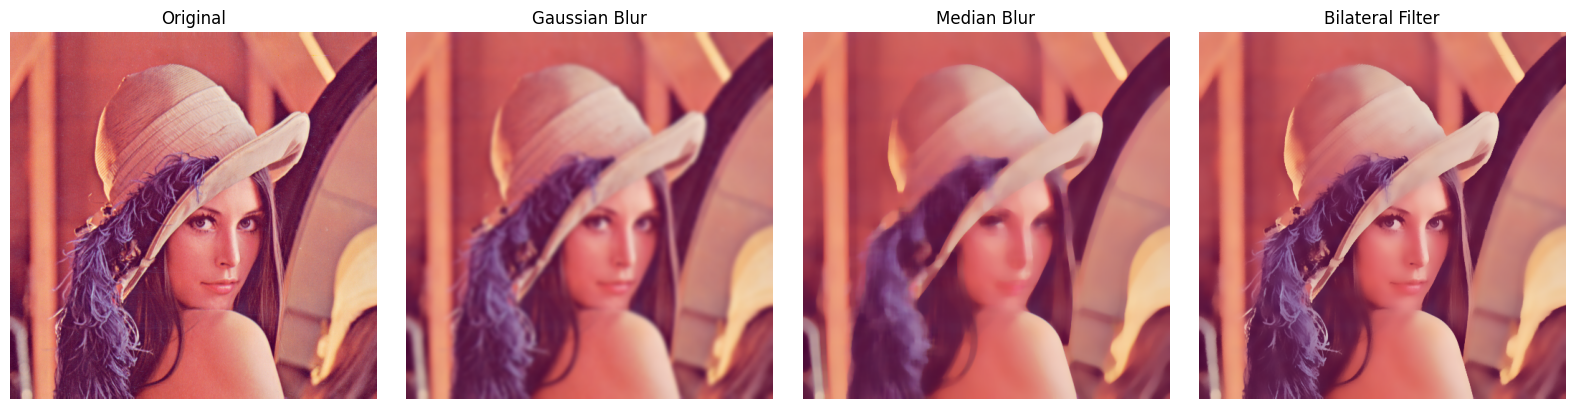

In [148]:
# Gaussian Blur - размытие по Гауссу
# (15, 15) - размер ядра, 0 - sigma (вычисляется автоматически)
gaussian = cv2.GaussianBlur(img_cv, (15, 15), 0)
gaussian = cv2.cvtColor(gaussian, cv2.COLOR_BGR2RGB)

# Median Blur - медианный фильтр, хорош для удаления шума
# 15 - размер ядра (должен быть нечетным)
median = cv2.medianBlur(img_cv, 15)
median = cv2.cvtColor(median, cv2.COLOR_BGR2RGB)

# Bilateral Filter - сохраняет границы при размытии
# 15 - диаметр пикселя, 80 - sigma color, 80 - sigma space
bilateral = cv2.bilateralFilter(img_cv, 15, 80, 80)
bilateral = cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gaussian)
plt.title('Gaussian Blur')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(median)
plt.title('Median Blur')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(bilateral)
plt.title('Bilateral Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

## Морфологические операции

## Где применять морфологические фильтры?

### Erosion (Эрозия)
**Применение:**
- Удаление мелких белых шумов на бинарном изображении
- Разделение соприкасающихся объектов
- Утончение линий и контуров

**Пример задач:**
- Разделить слипшиеся буквы в OCR
- Убрать мелкие артефакты после бинаризации
- Найти скелет объекта (skeleton extraction)

### Dilation (Расширение)
**Применение:**
- Заполнение маленьких дыр в объектах
- Соединение близких компонентов
- Усиление слабых краев

**Пример задач:**
- Соединить разорванные линии текста
- Увеличить область детекции объекта
- Заполнить пробелы в контурах

### Opening (Открытие = Erosion → Dilation)
**Применение:**
- Удаление мелкого шума (точки, линии)
- Сглаживание контуров
- Отделение объектов, соединенных тонкой перемычкой

**Пример задач:**
- Очистка отсканированных документов от артефактов сканера
- Удаление "соль и перец" шума после бинаризации
- Предобработка перед подсчетом объектов

### Closing (Закрытие = Dilation → Erosion)
**Применение:**
- Заполнение маленьких дыр внутри объектов
- Соединение близких компонентов
- Сглаживание контуров объектов

**Пример задач:**
- Заполнить разрывы в буквах (О, В, Д, Я)
- Соединить фрагменты одного объекта
- Улучшить маски сегментации

### Реальные примеры использования:

**OCR системы (распознавание текста):**
- Opening → убрать шум вокруг букв
- Closing → заполнить разрывы внутри букв

**Медицинская визуализация:**
- Closing → объединить фрагменты органа на МРТ
- Opening → удалить мелкие сосуды/артефакты

**Детекция объектов:**
- Closing → улучшить маски после детекции
- Erosion → найти ядра клеток (центры объектов)

**Анализ документов:**
- Opening → убрать шум на старых документах
- Closing → соединить разорванные линии таблиц

**Сегментация:**
- Erosion → разделить касающиеся объекты (например, яблоки в куче)
- Dilation → восстановить размер после erosion

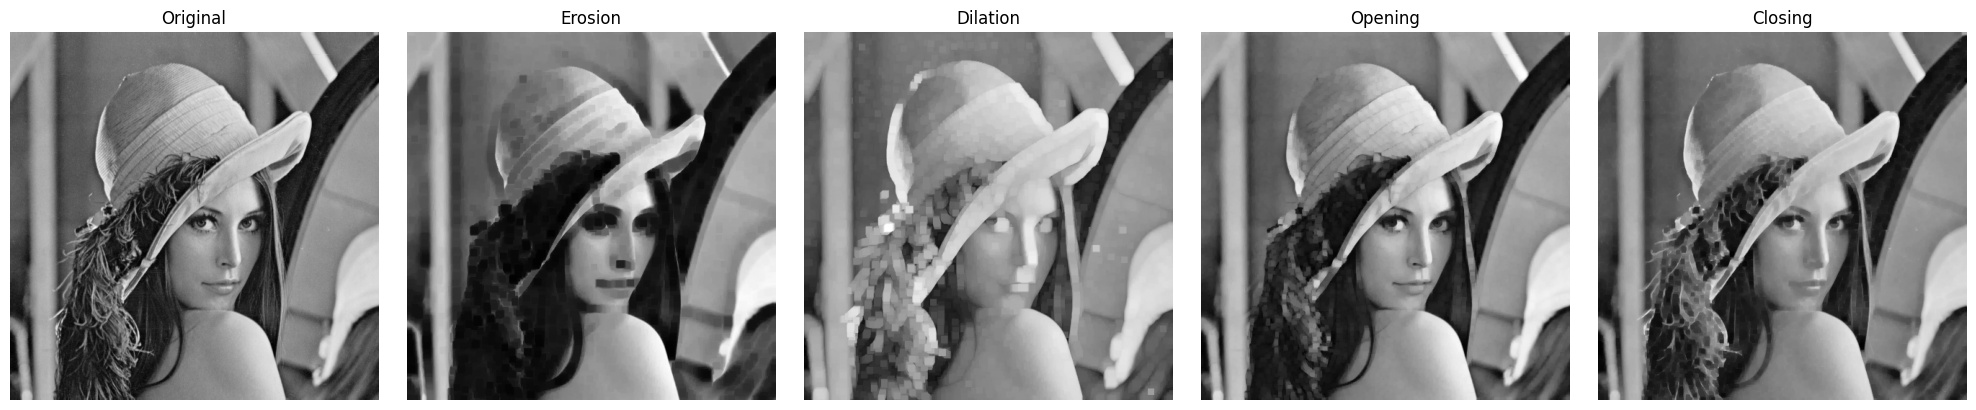

In [13]:
# Создаем ядро для морфологических операций
kernel = np.ones((5, 5), np.uint8)

# Erosion - "съедает" границы объектов
erosion = cv2.erode(gray, kernel, iterations=2)

# Dilation - расширяет объекты
dilation = cv2.dilate(gray, kernel, iterations=2)

# Opening - erosion затем dilation (убирает шум)
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

# Closing - dilation затем erosion (заполняет дыры)
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(20, 4))

plt.subplot(1, 5, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(dilation, cmap='gray')
plt.title('Dilation')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(opening, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(closing, cmap='gray')
plt.title('Closing')
plt.axis('off')

plt.tight_layout()
plt.show()

## Laplacian и повышение резкости

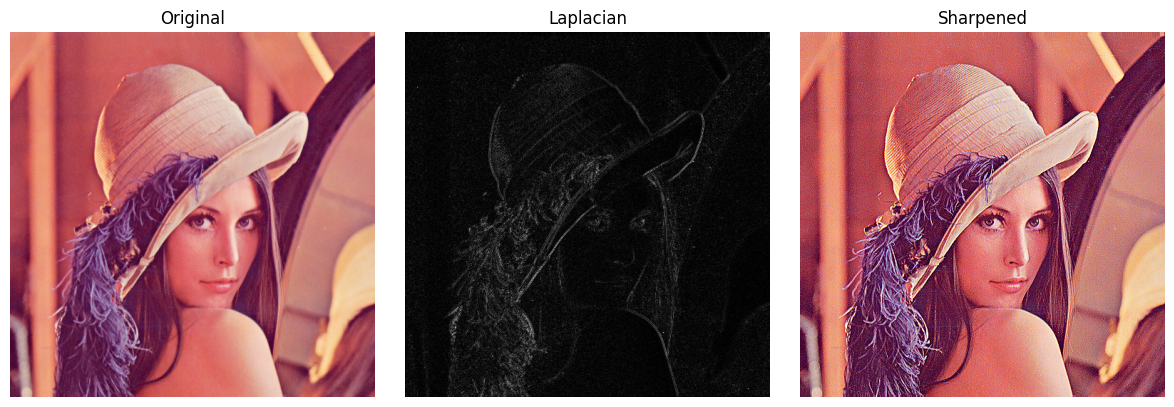

In [14]:
# Laplacian - детектирование границ
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))

# Sharpening - повышение резкости
# Создаем ядро для sharpening
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened = cv2.filter2D(img_cv, -1, kernel_sharpen)
sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sharpened)
plt.title('Sharpened')
plt.axis('off')

plt.tight_layout()
plt.show()

## Пример подготвки данных для задачи OCR

--2025-11-25 01:51:47--  https://i.sstatic.net/2f9hR.jpg
Resolving i.sstatic.net (i.sstatic.net)... 198.252.206.17
Connecting to i.sstatic.net (i.sstatic.net)|198.252.206.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106129 (104K) [image/jpeg]
Saving to: ‘text_image.jpg’

text_image.jpg      100%[===================>] 103.64K  --.-KB/s    in 0.01s   

2025-11-25 01:51:47 (9.10 MB/s) - ‘text_image.jpg’ saved [106129/106129]

Типичный pipeline обработки документа перед OCR:

1. Gaussian Blur - убираем шум
2. Adaptive Threshold - бинаризация с учетом локального освещения
3. Closing - заполняем разрывы в буквах


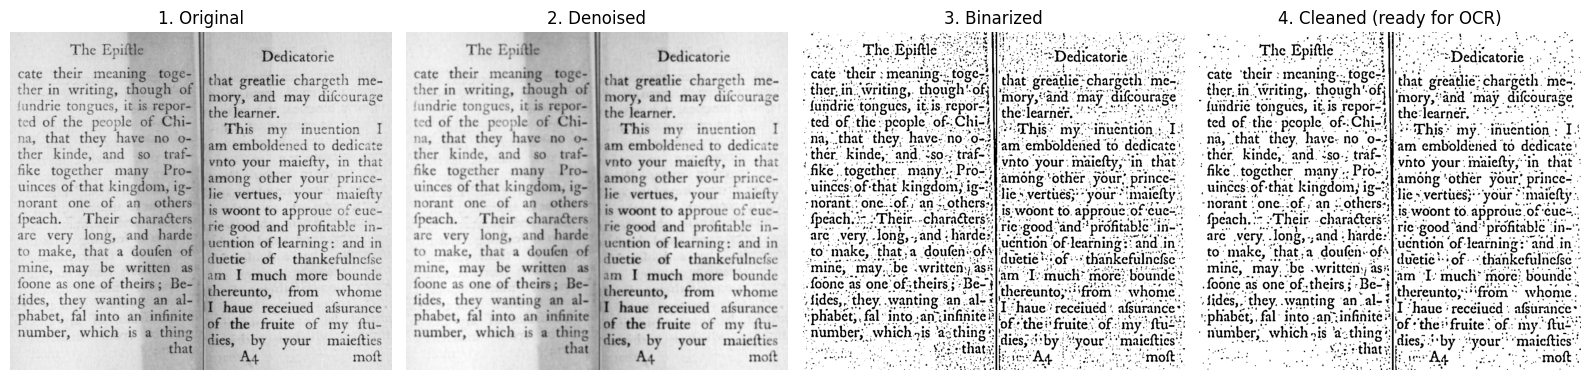


Теперь изображение готово для подачи в Tesseract OCR


In [15]:
# Скачиваем изображение
!wget https://i.sstatic.net/2f9hR.jpg -O text_image.jpg

# Загружаем
img_text = cv2.imread("text_image.jpg")
gray_text = cv2.cvtColor(img_text, cv2.COLOR_BGR2GRAY)

print("Типичный pipeline обработки документа перед OCR:")
print()

# Шаг 1: Убираем шум с помощью Gaussian Blur
# cv2.GaussianBlur(src, ksize, sigmaX)
# ksize=(5,5) - размер ядра свертки (должен быть нечетным)
# sigmaX=0 - стандартное отклонение по X (вычисляется автоматически)
step1 = cv2.GaussianBlur(src=gray_text, ksize=(5, 5), sigmaX=0)
print("1. Gaussian Blur - убираем шум")

# Шаг 2: Адаптивная бинаризация
# cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)
# maxValue=255 - значение для белого пикселя
# adaptiveMethod - метод вычисления порога (GAUSSIAN_C использует взвешенное среднее)
# thresholdType - тип бинаризации (BINARY: если > порога, то белый)
# blockSize=11 - размер области для вычисления порога (должен быть нечетным)
# C=2 - константа, вычитаемая из среднего (тонкая настройка)
step2 = cv2.adaptiveThreshold(src=step1,
                               maxValue=255,
                               adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               thresholdType=cv2.THRESH_BINARY,
                               blockSize=11,
                               C=2)
print("2. Adaptive Threshold - бинаризация с учетом локального освещения")

# Шаг 3: Морфологическая операция Closing
# Сначала создаем ядро (kernel) для морфологии
kernel = np.ones((2, 2), np.uint8)
# cv2.morphologyEx(src, op, kernel)
# op=MORPH_CLOSE - операция closing (dilation + erosion)
# kernel - структурирующий элемент
step3 = cv2.morphologyEx(src=step2, op=cv2.MORPH_CLOSE, kernel=kernel)
print("3. Closing - заполняем разрывы в буквах")

# Визуализация всех шагов
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(gray_text, cmap='gray')
plt.title('1. Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(step1, cmap='gray')
plt.title('2. Denoised')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(step2, cmap='gray')
plt.title('3. Binarized')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(step3, cmap='gray')
plt.title('4. Cleaned (ready for OCR)')
plt.axis('off')

plt.tight_layout()
plt.show()

print()
print("Теперь изображение готово для подачи в Tesseract OCR")

Все действия по редактированию картинки сводятся к математике. Например, чтобы осветлить картинку, нужно прибавить к каждому пикселю какое-то число. Часто такие математические действия над картинками записывают в виде операции свёртки. Свёртка принимает на вход одну картинку, а на выход отдаёт новую, переработанную.

## Задание 1

Давайте поиграемся с размерами картинки. Укажите значения для ресайза исходного изображения.

In [16]:
print("Давайте изменим размер и обрежем изображение")
print(f"Исходный размер: {img_rgb.shape[:2]}")
print()

# Уменьшаем изображение до 200x200
print("1. Уменьшаем до 200x200 пикселей")
small = ...

# Увеличиваем изображение до 800x800
print("2. Увеличиваем до 800x800 пикселей")
large = ...

# Обрезаем центральную часть (50% от ширины и высоты)
h, w = img_rgb.shape[:2]
crop_h_start = ...  # начинаем с 25% высоты
crop_h_end = ...  # заканчиваем на 75% высоты
crop_w_start = ...  # начинаем с 25% ширины
crop_w_end = ...  # заканчиваем на 75% ширины

print(f"3. Обрезаем центр: [{crop_h_start}:{crop_h_end}, {crop_w_start}:{crop_w_end}]")
cropped = img_rgb[crop_h_start:crop_h_end, crop_w_start:crop_w_end]
print(f"   Размер после обрезки: {cropped.shape[:2]}")

# Визуализация
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(small)
plt.title(f'Small {small.shape[1]}x{small.shape[0]}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_rgb)
plt.title(f'Original {img_rgb.shape[1]}x{img_rgb.shape[0]}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cropped)
plt.title(f'Cropped {cropped.shape[1]}x{cropped.shape[0]}')
plt.axis('off')

plt.tight_layout()
plt.show()

Давайте изменим размер и обрежем изображение
Исходный размер: (512, 512)

1. Уменьшаем до 200x200 пикселей
2. Увеличиваем до 800x800 пикселей
3. Обрезаем центр: [Ellipsis:Ellipsis, Ellipsis:Ellipsis]


TypeError: slice indices must be integers or None or have an __index__ method

# 2. Пробуем применить свёртки к картинке, используя PyTorch

**Необязательное задание:** коллекция ручных задачек на свёртки.(https://fulyankin.github.io/deep_learning_masha_book/problem_set_05_conv/problem_01.html) Чтобы лучше почувствовать, как работают разные части свёрточных сеток, можно попробовать порешать эти задачки. К каждой из них на страничке есть решение.

### Класс torch.nn.Conv2d

In [17]:
import torch.nn as nn

nn.Conv2d

torch.nn.modules.conv.Conv2d

В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- `in_channels`: количество входных каналов
- `out_channels`: количество выходных каналов
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

#### `kernel_size`

**Размер ядра**. `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**`kernel_size=3`**

![no_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_no_strides.gif)


**Когда что использовать:**
- **3×3** - стандарт в современных CNN (VGG, ResNet). Баланс между вычислительной эффективностью и receptive field
- **5×5, 7×7** - больше контекста, но дороже вычислительно. Часто в первых слоях сети
- **1×1** - изменение количества каналов без изменения пространственных размеров (bottleneck слои)
- **Прямоугольные (3×1, 1×3)** - для вертикальных/горизонтальных паттернов. Дешевле чем 3×3 — редко используется

**Влияние на receptive field:**
- Больше ядро → больше receptive field за один слой
- Два слоя 3×3 = receptive field 5×5, но меньше параметров чем один слой 5×5
- Stack из нескольких маленьких ядер эффективнее одного большого

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic).


#### `stride`

**Шаг**. Задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**`stride=2`**

![no_padding_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_strides.gif)

**Когда что использовать:**
- **stride=1** - стандарт, сохраняет пространственное разрешение
- **stride=2** - уменьшает размер в 2 раза (альтернатива pooling). Используется для downsampling
- **stride>2** - редко, слишком агрессивная потеря информации

**Влияние на receptive field:**
- Больше stride → быстрее растет receptive field
- stride=2 удваивает receptive field следующих слоев
- Но теряем детализацию (не все пиксели обрабатываются)


#### `padding`

**Паддинг**. Количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**`padding=1`**

![same_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/same_padding_no_strides.gif)

**Когда что использовать:**
- **padding=0 (valid)** - без паддинга, размер уменьшается. Теряем информацию с краев
- **padding='same'** - размер выхода = размеру входа. Стандарт для большинства слоев
- **padding='valid'** - без паддинга, используется когда хотим уменьшить размер

**Формула для 'same':**
```
padding = (kernel_size - 1) // 2
Например: kernel=3 → padding=1
         kernel=5 → padding=2
```

**Влияние на receptive field:**
- Padding не влияет на receptive field напрямую
- Но позволяет сохранить пространственный размер → больше слоев → больше receptive field


### Класс MaxPool2d

In [111]:
import torch.nn as nn

nn.MaxPool2d

torch.nn.modules.pooling.MaxPool2d

В **PyTorch** уменьшает размерность, сохраняя наиболее «выразительные» признаки (максимумы), представлен в модуле `torch.nn` классом [`MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) с параметрами:
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг (по умолчанию 0)
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

![MaxPooling.png](https://media.geeksforgeeks.org/wp-content/uploads/Screenshot-from-2017-08-15-17-04-02.png)

Изображение взято [здесь](https://www.geeksforgeeks.org/computer-vision/apply-a-2d-max-pooling-in-pytorch/).

## Receptive Field

**Receptive field** - область входного изображения, которая влияет на один выходной пиксель.

**Как увеличить receptive field:**
1. Больше слоев (предпочтительно)
2. Больше kernel_size
3. Больше stride (но теряем детали)
4. Добавить pooling
5. Использовать dilated convolutions

**Примеры:**
```
1 слой 3×3:           RF = 3×3
2 слоя 3×3:           RF = 5×5
3 слоя 3×3:           RF = 7×7
1 слой 7×7:           RF = 7×7 (но больше параметров!)

С stride=2:
1 слой 3×3, stride=2: RF = 3×3
2 слоя 3×3, stride=2: RF = 7×7 (растет быстрее!)
```

### Класс Flatten

В **PyTorch** операция выпрямления (преобразования многомерного тензора в вектор) представлена в модуле torch.nn классом [`Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

In [112]:
import torch.nn as nn

nn.Flatten

torch.nn.modules.flatten.Flatten

![Flatten.png](https://raw.githubusercontent.com/hse-ds/iad-deep-learning/refs/heads/master/2024/seminars/02.%20Image%20Convolution/static/Flatten.png)

## Свёртка изображений

Чем может быть полезна свертка при работе с изображениями? Свертки детектируют **паттерны на картинках** – цвета и сочетания цветов, небольшие объекты. Обычно значения свертки являются обучаемыми параметрами нейрости. Однако существуют "готовые" свертки, настроенные на определенные паттерны.

Например, оператор Собеля (свертка с определенными параметрами) используется для детекции границ на изображении. Применим этот оператор. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`.

In [32]:
import torch

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [33]:
import torch

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d

In [34]:
img_matrix = np.array(img_np)
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 512, 512])

Зададим оператор Собеля для детектирования горизонтальных границ

In [35]:
sobel_hor = [
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [36]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 510, 510, 1])

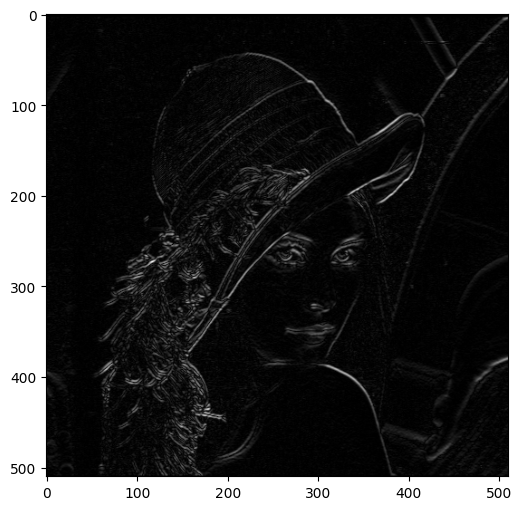

In [37]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]), cmap='gray');

Проделаем то же самое для детектирования вертикальных границ

In [38]:
sobel_ver = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 510, 510, 1])

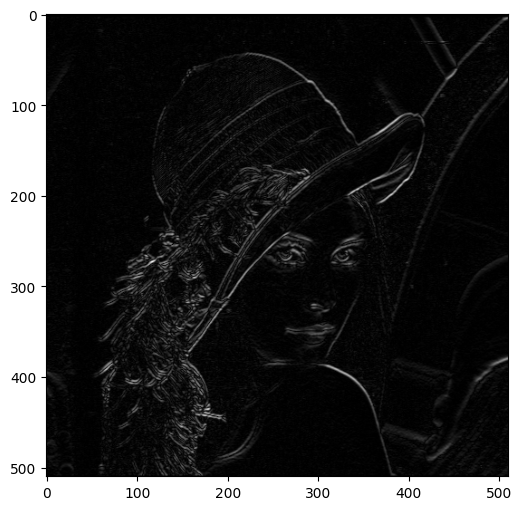

In [39]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]), cmap='gray');

Объединим два изображения

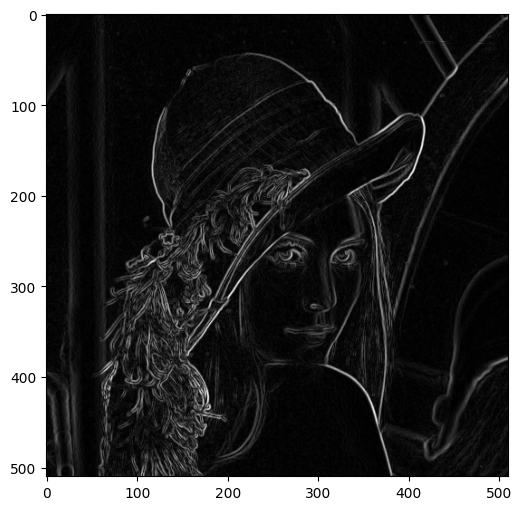

In [40]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0], cmap='gray');

# 3. Обучаем нейросети для Computer Vision

## Современный стек для CV

Сразу окунёмся в профессиональные инструменты:
1. **timm** - библиотека с сотнями предобученных моделей (https://github.com/huggingface/pytorch-image-models)
2. **albumentations** - быстрые и мощные аугментации для изображений (https://albumentations.ai/)
3. **Transfer Learning** - как использовать знания из больших датасетов

Начнем с простого примера на MNIST, а затем перейдем к transfer learning.

In [49]:
!pip install timm albumentations -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.datasets import MNIST

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

print(f"PyTorch: {torch.__version__}")
print(f"timm: {timm.__version__}")
print(f"albumentations доступен")

PyTorch: 2.9.0+cu126
timm: 1.0.22
albumentations доступен


## Загрузка данных MNIST (классический подход)

In [50]:
# Классические трансформации через torchvision
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))  # mean и std для MNIST (посчитаны на train set)
])

train_set = MNIST('.MNIST', transform=transform, train=True, download=True)
val_set = MNIST('.MNIST', transform=transform, train=False, download=True)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=4096, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_set)}")
print(f"Val samples: {len(val_set)}")

# Посмотрим на данные
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")  # [batch_size, channels, height, width]

Train samples: 60000
Val samples: 10000
Batch shape: torch.Size([256, 1, 28, 28])


## Визуализация данных

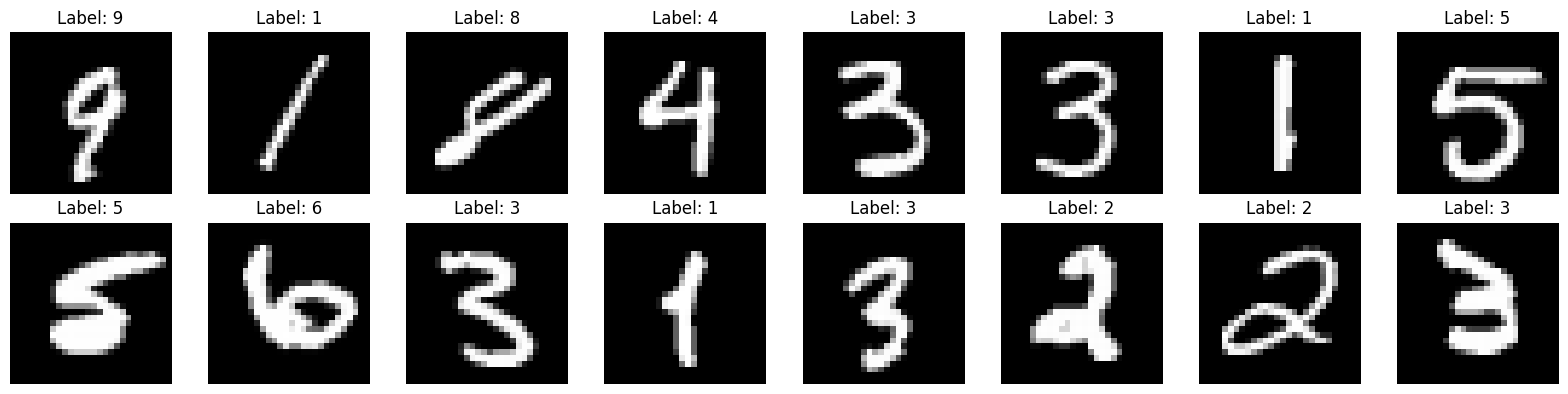

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Показываем несколько примеров
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for idx, ax in enumerate(axes.flat):
    img = images[idx].squeeze()  # убираем channel dimension
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[idx].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Наша первая свёрточная сеточка


### Задание 2 (5-7 минут)

Давайте по кубикам соберём наш метод `forward`, который содержит в себе инициализированные атрибуты в `__init__`.

**Алгоритм (что нужно сделать в forward):**

1. Свёрточный слой `conv1` с 16 ядрами размером 3×3
2. Функция активации ReLU
3. MaxPooling - уменьшить картинку в 2 раза (28×28 → 14×14)
4. Свёрточный слой `conv2` с 32 ядрами размером 3×3
5. Функция активации ReLU
6. MaxPooling - уменьшить картинку в 2 раза (14×14 → 7×7)
7. Flatten - превратить [batch, 32, 7, 7] → [batch, 32×7×7]
8. Fully connected слой `fc1` (32×7×7 → 128)
9. Функция активации ReLU
10. Fully connected слой `fc2` (128 → 10 классов)

ВАЖНО! Не забываем про функцию активации ReLU после каждого слоя (кроме последнего)!

Подсказка: используем `F.relu`, `self.pool`, `x.view(x.size(0), -1)`

In [149]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected
        # После двух pooling: 28 -> 14 -> 7
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    # def forward(self, x):
    #     # your code here
    #     # =^･ｪ･^=

    #     # Conv block 1: 28x28 -> 14x14

    #     # Conv block 2: 14x14 -> 7x7

    #     # Flatten: превращаем [batch, channels, height, width] -> [batch, channels*height*width]

    #     # FC layers

    #     return x


# Создаем модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = ConvNet(num_classes=10).to(device)

print(f"ConvNet parameters: {sum(p.numel() for p in model_conv.parameters()):,}")
print(f"\nАрхитектура:\n{model_conv}")

ConvNet parameters: 206,922

Архитектура:
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Подготовим функции для обучения. WandB как иснструмент для логгирования результатов тут вынесен в отдельную опцию, чтобы им можно было пользоваться только при желании.

In [150]:
# !pip install wandb -qU

In [151]:
# import wandb
# wandb.login()

In [152]:
import wandb
from tqdm import tqdm
from IPython.display import clear_output

def training_epoch(model, optimizer, criterion, train_loader, device, tqdm_desc, use_wandb=False):
    """Одна эпоха обучения"""
    train_loss = 0.0
    train_accuracy = 0.0
    model.train()

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Логируем batch метрики
        if use_wandb:
            wandb.log({"batch/train_loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, device, tqdm_desc):
    """Прогнозы на валидации"""
    val_loss = 0.0
    val_accuracy = 0.0
    model.eval()

    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy


def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    """Визуализация процесса обучения"""
    clear_output(wait=True)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over epochs')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(train_accuracies, label='Train Accuracy')
    axes[1].plot(val_accuracies, label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy over epochs')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, device,
          scheduler=None, use_wandb=False, wandb_config=None):
    """Обучение модели"""

    # Инициализируем wandb
    if use_wandb:
        wandb.init(
            project=wandb_config.get('project', 'mnist-convnet'),
            config=wandb_config,
            name=wandb_config.get('run_name', None)
        )
        wandb.watch(model, log='all', log_freq=100)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader, device,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            use_wandb=use_wandb
        )
        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader, device,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Меняем learning rate по расписанию
        if scheduler is not None:
            scheduler.step()

        # Логируем epoch метрики в wandb
        if use_wandb:
            wandb.log({
                "epoch": epoch,
                "train/loss": train_loss,
                "train/accuracy": train_accuracy,
                "val/loss": val_loss,
                "val/accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        # Визуализируем прогресс
        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

        # Печатаем метрики
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    if use_wandb:
        wandb.finish()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [153]:
# Параметры обучения
NUM_EPOCHS = 2
LEARNING_RATE = 0.001

# Создаем модель
model_conv = ConvNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Конфигурация для wandb
wandb_config = {
    'project': 'mnist-convnet',
    'run_name': 'convnet-baseline',
    'architecture': 'ConvNet',
    'dataset': 'MNIST',
    'epochs': NUM_EPOCHS,
    'batch_size': 256,
    'learning_rate': LEARNING_RATE,
    'optimizer': 'Adam',
    'scheduler': 'StepLR'
}

# Обучаем с wandb логированием
train_losses, val_losses, train_accs, val_accs = train(
    model=model_conv,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    scheduler=scheduler,
    use_wandb=True,
    wandb_config=wandb_config
)

print(f"\nFinal Results:")
print(f"Train Accuracy: {train_accs[-1]:.4f}")
print(f"Val Accuracy: {val_accs[-1]:.4f}")

Training 1/2:   0%|          | 0/391 [00:00<?, ?it/s]


NotImplementedError: Module [ConvNet] is missing the required "forward" function

## Инференс

Давайте попробуем построить предсказания на валидационной выборке и посмотрим на примеры картинок, где модель ошиблась. Иногда бывает полезно отсматривать конкретные примеры ошибок, чтобы подумать как можно улучшить модель.

### Задание 3
Восстановите пропущенные участки кода

In [ ]:
def predict(model, val_loader, device):
    X, y, logit = [], [], []

    # ???
    # model.eval() OR model.train()

    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        # Сохраняем батчи
        X.append(x_batch.cpu().numpy())
        y.append(y_batch.cpu().numpy())

        # Инференс
        x_batch = x_batch.to(device)


        # Помимо прокидывания батча в модель, что мы ещё здесь забыли навесить?
        logits = ...

        # Получаем предсказания (индексы классов)
        predictions = ...
        logit.append(predictions)

    # Объединяем все батчи
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    logit = np.concatenate(logit, axis=0)

    return X, y, logit


# Получаем предсказания
X_test, y_test, y_pred = predict(model_conv, val_loader, device)

print(f"X_test shape: {X_test.shape}")  # (10000, 1, 28, 28)
print(f"y_test shape: {y_test.shape}")  # (10000,)
print(f"y_pred shape: {y_pred.shape}")  # (10000,)

In [ ]:
# Находим ошибки
errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

print(f"Количество ошибок: {errors.sum()} из {len(y_test)}")
print(f"Accuracy: {100 * (1 - errors.sum() / len(y_test)):.2f}%\n")

# Визуализируем ошибки
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))

for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')

        img = X_err[random_index].squeeze()  # убираем channel dimension
        ax.imshow(img, cmap='gray')

        ax.set_title(f'Real: {y_err[random_index]}\nPred: {y_pred_err[random_index]}')

plt.suptitle('Примеры ошибок модели', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Посмотрим на то, путает ли модель систематически одни классы с другими. Чтобы лучше было видно занулим диагональ у `confusion_matrix`.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Строим confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
cm = cm - np.eye(10) * cm.diagonal()  # Зануляем диагональ

plt.figure(figsize=(8, 7))
plt.title('Confusion Matrix (без диагонали)', fontsize=16)
plt.imshow(cm, cmap='Reds')

plt.xlabel('Predicted Label (что предсказала модель)', fontsize=12)
plt.ylabel('True Label (правильный класс)', fontsize=12)

plt.xticks(np.arange(10), np.arange(10), fontsize=12)
plt.yticks(np.arange(10), np.arange(10), fontsize=12)

plt.colorbar(label='Доля от всех примеров')
plt.tight_layout()
plt.show()

print("Интерпретация:")
print("- Яркие клетки показывают какие классы модель чаще всего путает")
print("- Например, если клетка [4, 9] яркая, значит цифру 4 часто путают с 9")

# 4. Современные подходы: Transfer Learning

До этого мы обучали простую ConvNet с нуля на MNIST. Но в реальной жизни так почти никто не делает!

**Проблема обучения с нуля:**
- Нужно много данных (миллионы изображений)
- Долгое обучение (дни/недели на GPU)
- Нужна экспертиза в подборе архитектуры
- Легко переобучиться на маленьких датасетах

**Решение - Transfer Learning:**
Берем модель, обученную на огромном датасете (ImageNet - 14M изображений, 1000 классов), и дообучаем на нашей задаче!

**Почему это работает?**
- Первые слои учат универсальные признаки: edges, textures, colors
- Средние слои - более сложные паттерны: parts, shapes
- Последние слои - специфичные признаки для конкретной задачи

Мы "переносим" знания (transfer) из одной задачи в другую!

## Библиотека `timm`

In [115]:
!pip install timm -q

import timm

print(f"timm версия: {timm.__version__}")
print(f"Всего доступных моделей: {len(timm.list_models())}\n")

# Посмотрим на популярные семейства архитектур
print("Популярные архитектуры:")
print(f"  ResNet: {len(timm.list_models('resnet*'))} моделей")
print(f"  EfficientNet: {len(timm.list_models('efficientnet*'))} моделей")
print(f"  Vision Transformers: {len(timm.list_models('vit*'))} моделей")
print(f"  ConvNeXt: {len(timm.list_models('convnext*'))} моделей")

print("\nПримеры ResNet моделей:")
for model_name in timm.list_models('resnet*')[:8]:
    print(f"  - {model_name}")

timm версия: 1.0.22
Всего доступных моделей: 1279

Популярные архитектуры:
  ResNet: 75 моделей
  EfficientNet: 42 моделей
  Vision Transformers: 204 моделей
  ConvNeXt: 28 моделей

Примеры ResNet моделей:
  - resnet10t
  - resnet14t
  - resnet18
  - resnet18d
  - resnet26
  - resnet26d
  - resnet26t
  - resnet32ts


## Обзор популярных архитектур

В Computer Vision существует множество архитектур, каждая со своими особенностями. Вот краткий обзор самых популярных:

### ResNet (2015) - Residual Networks

**Ключевая идея:** Skip connections (остаточные связи)

<div align="center">
  <img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png" width="600" alt="ResNet Skip Connection">
  <p><i>Residual block с skip connection</i></p>
</div>

**Как это работает:**
```python
# Обычный блок (без skip connection)
def plain_block(x):
    x = conv1(x)
    x = relu(x)
    x = conv2(x)
    x = relu(x)
    return x

# Residual block (с skip connection)
def residual_block(x):
    identity = x  # Сохраняем вход
    
    x = conv1(x)
    x = relu(x)
    x = conv2(x)
    
    x = x + identity  # Добавляем оригинальный вход!
    x = relu(x)
    return x
```

**Особенности:**
- Решает проблему vanishing gradients
- Позволяет обучать очень глубокие сети (50, 101, 152 слоя)
- Простая и эффективная архитектура
- Градиенты могут "течь" напрямую через skip connections


### MobileNet (2017) - Efficient CNN для Mobile

**Ключевая идея:** Depthwise Separable Convolutions (разделяемые свёртки)

<div align="center">
  <img src="https://machinethink.net/images/mobilenets/DepthwiseConvolution@2x.png" width="600" alt="MobileNet Depthwise Separable Convolution">
  <p><i>Depthwise Separable Convolution: два этапа вместо одного</i></p>
</div>

**Как это работает:**

Обычная свёртка делает всё за раз. MobileNet разбивает на 2 шага:

1. **Depthwise:** 3×3 фильтр применяется к каждому каналу отдельно
2. **Pointwise (1×1):** Комбинирует результаты между каналами

**Экономия вычислений:**
```
Обычная свёртка (3×3, 32→64 каналов):
Операций = 3 × 3 × 32 × 64 = 18,432

Depthwise Separable:
Depthwise:  3 × 3 × 32 = 288
Pointwise:  1 × 1 × 32 × 64 = 2,048
Итого: 2,336 операций

Ускорение: 18,432 / 2,336 ≈ 8x быстрее!
```

**Особенности:**
- В 8-9 раз меньше параметров и вычислений
- Минимальная потеря точности (~1%)
- Идеально для mobile и embedded devices
- Версии: V1, V2 (+ inverted residuals), V3 (+ NAS)

**Когда использовать:**
- Мобильные приложения
- Real-time inference на слабых устройствах
- Когда важна скорость работы

**Сравнение:**
- ResNet-50: 25M параметров
- MobileNet-V2: 3.5M параметров (7x меньше!)

### EfficientNet (2019) - Compound Scaling

**Ключевая идея:** Одновременное масштабирование глубины, ширины и разрешения

<div align="center">
  <img src="https://cdn.prod.website-files.com/680a070c3b99253410dd3df5/68b1d4cd2ba68bbd0c88508d_EfficientNet_fig3.webp" width="700" alt="EfficientNet Compound Scaling">
  <p><i>Compound Scaling vs традиционные подходы</i></p>
</div>

**Традиционный подход (неэффективный):**
- **(b) Увеличить только ширину** (больше каналов) → теряет способность захватывать сложные признаки
- **(c) Увеличить только глубину** (больше слоёв) → сложно обучать, быстро насыщается
- **(d) Увеличить только разрешение** (больше пикселей) → дорого вычислительно без пользы

**EfficientNet подход (e) - Compound Scaling:**

Масштабирует все три параметра одновременно по формуле:
```
depth:      d = α^φ
width:      w = β^φ  
resolution: r = γ^φ

где α × β² × γ² ≈ 2
φ - коэффициент масштабирования
```

**Почему это работает:**

Интуиция: более глубокая сеть нуждается в более широких слоях и высоком разрешении, чтобы эффективно использовать дополнительную глубину. Все три измерения работают вместе!

**Семейство моделей:**

| Модель | Параметры | ImageNet Top-1 | Относительная скорость |
|--------|-----------|----------------|------------------------|
| EfficientNet-B0 | 5.3M | 77.1% | ⚡⚡⚡⚡ (baseline) |
| EfficientNet-B1 | 7.8M | 79.1% | ⚡⚡⚡ |
| EfficientNet-B3 | 12M | 81.6% | ⚡⚡ |
| EfficientNet-B5 | 30M | 83.6% | ⚡ |
| EfficientNet-B7 | 66M | 84.3% | 🐌 |

**Особенности:**
- Лучший баланс точность/эффективность
- Найдено через Neural Architecture Search (NAS)
- B0 - базовая архитектура, B1-B7 - compound scaling
- MBConv блоки + Squeeze-and-Excitation

**Когда использовать:**
- Production системы с ограничениями по ресурсам
- Когда нужен баланс точность/скорость
- B0 для прототипов, B3-B5 для высокой точности

**Практический совет:**
Начинайте с B0, если не хватает точности - пробуйте B1-B3. B7 только для максимальной точности.

### Vision Transformer (ViT, 2020) - Attention is All You Need

**Ключевая идея:** Применить Transformer архитектуру (из NLP) к изображениям

<div align="center">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20250108160202257232/Vision-Transformer-Architecture_.webp" width="800" alt="Vision Transformer Architecture">
  <p><i>ViT: изображение → патчи → embeddings → Transformer → классификация</i></p>
</div>

**Как это работает:**

1. **Patch Embedding:** Разбиваем изображение на патчи (например, 16×16 пикселей)
   - 224×224 изображение → 14×14 = 196 патчей
   - Каждый патч проецируется в вектор

2. **Position Embedding:** Добавляем информацию о позиции патча
   - Transformer не знает порядок, нужно явно указать

3. **[CLS] Token:** Специальный токен для классификации
   - Аналог [CLS] из BERT

4. **Transformer Encoder:** N слоёв Multi-Head Self-Attention
   - Каждый патч "смотрит" на все остальные

5. **MLP Head:** Финальная классификация

**Ключевое отличие от CNN:**

| CNN | Vision Transformer |
|-----|-------------------|
| Локальные операции (3×3 окно) | Глобальные операции (все патчи) |
| Inductive bias (локальность) | Учит структуру с нуля |
| Хорошо на малых данных | Требует много данных (>100M) |
| Быстрый inference | Медленный inference |

**Математика:**
```
Patch Embedding: 224×224×3 → 196 патчей × 768 dim
Position Encoding: добавляем learned embeddings
Self-Attention: каждый патч видит ВСЕ остальные

Attention(Q, K, V) = softmax(QK^T / √d) × V
```

**Семейство моделей:**

| Модель | Параметры | Патчи | ImageNet Top-1 | Данные |
|--------|-----------|-------|----------------|--------|
| ViT-Base/16 | 86M | 16×16 | 81.8% | 300M images |
| ViT-Large/16 | 307M | 16×16 | 85.2% | 300M images |
| ViT-Huge/14 | 632M | 14×14 | 88.5% | 300M images |

**Особенности:**
- State-of-the-art точность на больших датасетах
- Вообще не использует свёртки! Но есть нюанс!
- Требует предобучения на огромных данных
- Лучше масштабируется чем CNN (bigger is better)
- Multi-Head Attention позволяет "видеть" всё изображение

**Когда использовать:**
- Доступ к предобученным весам (обязательно!)
- Нужна максимальная точность
- Research задачи
- Много вычислительных ресурсов

**Когда НЕ использовать:**
- Маленький датасет без предобучения
- Нужна скорость (real-time inference)
- Ограниченные ресурсы (mobile/edge)

**Важно:** ViT с нуля на маленьких данных работает хуже ResNet. Всегда используйте предобученные веса!

### ConvNeXt (2022) - Modernized ConvNet

**Ключевая идея:** Взять лучшие идеи из Transformers и применить к свёрточным сетям

<div align="center">
  <img src="https://docsaid.org/en/assets/images/img3-85ad8b25b47e67d8c67d3ebcd89ba0b7.jpg" width="800" alt="ConvNeXt Architecture">
  <p><i>Эволюция от ResNet-50 к ConvNeXt: постепенная модернизация</i></p>
</div>

**История создания:**

Вопрос: Может ли CNN конкурировать с Transformers в 2020-х?

Подход: Берём ResNet-50 и постепенно модернизируем, добавляя успешные идеи из Vision Transformers и Swin Transformer (hierarchical ViT с shifted windows).

**Ключевые изменения (ResNet → ConvNeXt):**

1. **Training techniques** (81.8%) - современные методы обучения
2. **Macro design** (82.0%) - изменение количества блоков 3:4:6:3 → 3:3:9:3
3. **Patchify stem** (82.0%) - 4×4 stride-4 conv вместо 7×7 stride-2
4. **Depthwise conv** (82.0%) - как в MobileNet (эффективнее)
5. **Inverted bottleneck** (82.6%) - широкий средний слой (как в Transformers)
6. **Large kernel** (82.7%) - 7×7 свёртки вместо 3×3
7. **Micro design** (82.9%) - GELU, LayerNorm, меньше нормализаций

**Результат:**
```
ResNet-50:  76.1% ImageNet Top-1, 25M params
ConvNeXt-T: 82.1% ImageNet Top-1, 28M params (+6% точности!)
```

**Семейство моделей:**

| Модель | Параметры | ImageNet Top-1 | FLOPs |
|--------|-----------|----------------|-------|
| ConvNeXt-Tiny | 28M | 82.1% | 4.5G |
| ConvNeXt-Small | 50M | 83.1% | 8.7G |
| ConvNeXt-Base | 89M | 83.8% | 15.4G |
| ConvNeXt-Large | 198M | 84.3% | 34.4G |

**Сравнение архитектур:**

| | ResNet | ViT | ConvNeXt |
|---|---|---|---|
| **Тип** | CNN классика | Pure Transformer | Modern CNN |
| **Точность** | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Скорость** | ⚡⚡⚡⚡ | ⚡⚡ | ⚡⚡⚡ |
| **Малые данные** | ✅ Хорошо | ❌ Плохо | ✅ Хорошо |

**Когда использовать:**
- Современная альтернатива ResNet
- Transfer learning (работает на малых данных)
- Production (быстрее ViT, проще в deployment)
- Золотая середина: точность ViT + простота CNN

**Философия:**
CNN не умерли! С правильным дизайном они конкурируют с Transformers, оставаясь проще и эффективнее.

## Библиотека `albumentations` и датасет CIFAR-10

**Albumentations** - быстрая и гибкая библиотека для аугментации изображений в Computer Vision задачах.

**Почему Albumentations?**
- Быстрее чем torchvision (оптимизирован на C++)
- 80+ различных трансформаций
- Поддержка масок, bounding boxes, keypoints
- Используется в production (Kaggle competitions, research, industry)

In [133]:
!pip install albumentations -q

from torchvision.datasets import CIFAR10
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# Трансформации для обучения с Albumentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0),
    A.RandomCrop(height=32, width=32),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Трансформации для валидации
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class CIFAR10Albumentation(CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root=root, train=train, transform=None, download=download)
        self.album_transform = transform

    def __getitem__(self, idx):
        # Берем данные напрямую из self.data (это уже numpy array)
        image = self.data[idx]
        label = self.targets[idx]

        # Применяем Albumentations трансформации
        if self.album_transform:
            augmented = self.album_transform(image=image)
            image = augmented['image']

        return image, label

# Загружаем датасет
train_dataset = CIFAR10Albumentation(root='./data', train=True, download=True, transform=train_transform)
val_dataset = CIFAR10Albumentation(root='./data', train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Классы CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
print(f"\nКлассы: {classes}")

print("\nИспользуемые аугментации (Albumentations):")
print("- HorizontalFlip: горизонтальное отражение")
print("- RandomCrop: случайная обрезка с padding")
print("- ShiftScaleRotate: сдвиги, масштабирование, повороты")
print("- CoarseDropout: случайное затирание областей (Cutout)")

# Проверяем что работает
images, labels = next(iter(train_loader))
print(f"\nBatch test:")
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Train samples: 50000
Val samples: 10000

Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Используемые аугментации (Albumentations):
- HorizontalFlip: горизонтальное отражение
- RandomCrop: случайная обрезка с padding
- ShiftScaleRotate: сдвиги, масштабирование, повороты
- CoarseDropout: случайное затирание областей (Cutout)

Batch test:
Images shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


## Давайте взглянем, как работают наши аугментации

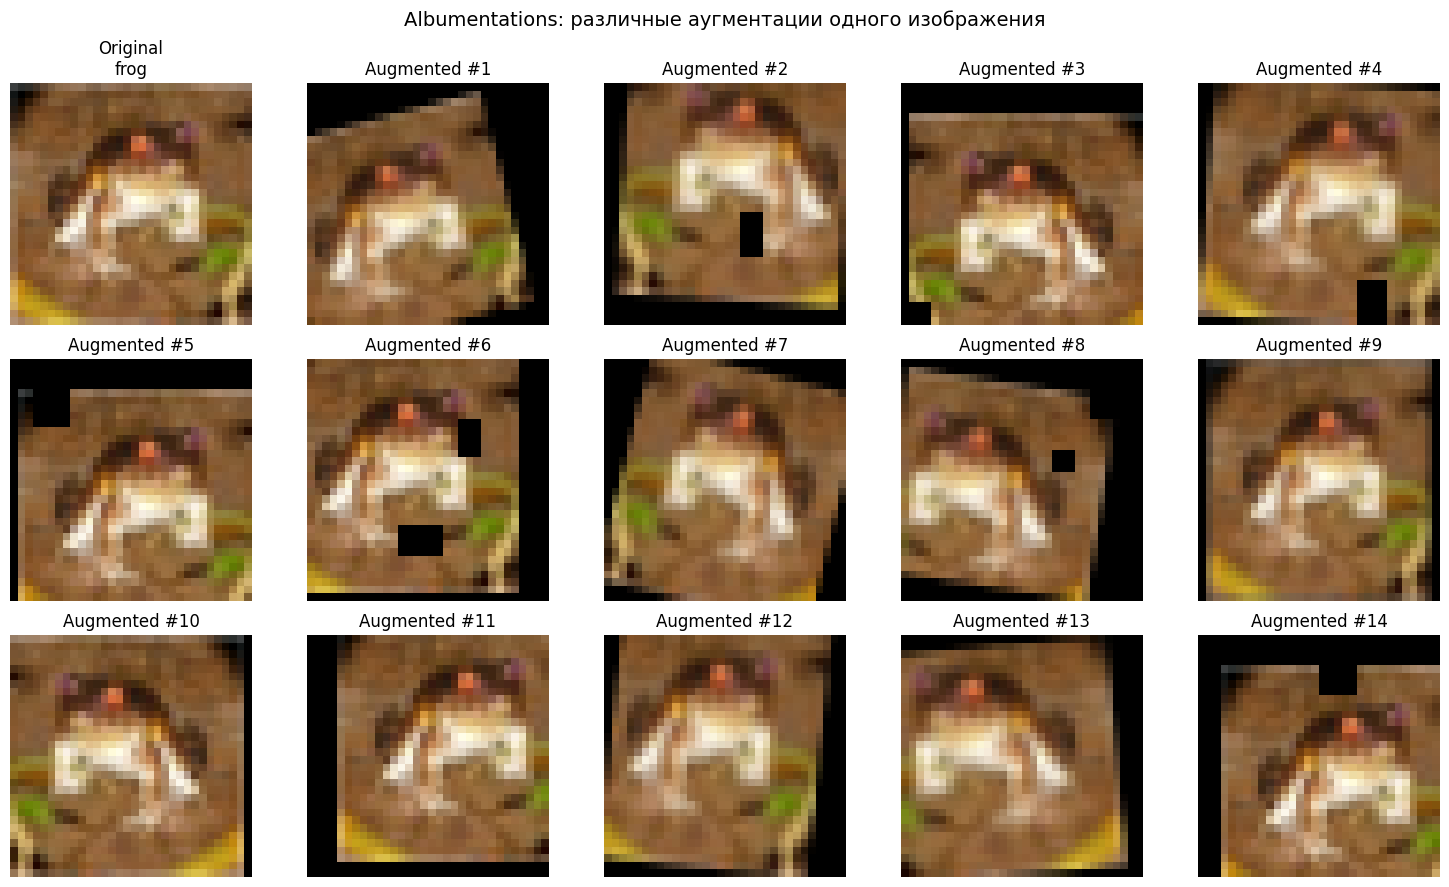

In [134]:
# Посмотрим как работают аугментации
# Берем одно изображение без аугментаций
from torchvision.datasets import CIFAR10

# Загружаем оригинальный датасет без трансформаций
cifar_original = CIFAR10(root='./data', train=True, download=False)
sample_img, sample_label = cifar_original[0]  # PIL Image
sample_img = np.array(sample_img)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

# Оригинал
axes[0].imshow(sample_img)
axes[0].set_title(f'Original\n{classes[sample_label]}')
axes[0].axis('off')

# Применяем аугментации 14 раз
for idx in range(1, 15):
    augmented = train_transform(image=sample_img)
    img_tensor = augmented['image']

    # Денормализуем для визуализации
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denorm = img_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)

    axes[idx].imshow(img_denorm.permute(1, 2, 0).numpy())
    axes[idx].set_title(f'Augmented #{idx}')
    axes[idx].axis('off')

plt.suptitle('Albumentations: различные аугментации одного изображения', fontsize=14)
plt.tight_layout()
plt.show()

## Создаем модель с Transfer Learning

In [135]:
# Загружаем предобученную ResNet18 из timm
model_pretrained = timm.create_model(
    'resnet18',
    pretrained=True,  # Веса обученные на ImageNet!
    num_classes=10    # Меняем последний слой под наши 10 классов
)

model_pretrained = model_pretrained.to(device)

print(f"Параметров в модели: {sum(p.numel() for p in model_pretrained.parameters()):,}")
print(f"\nПоследний слой (classifier):")
print(model_pretrained.fc)

Параметров в модели: 11,181,642

Последний слой (classifier):
Linear(in_features=512, out_features=10, bias=True)


## Стратегии Transfer Learning

Есть несколько подходов:

**1. Feature Extraction (заморозка весов)**
- Замораживаем все слои кроме последнего
- Обучаем только classifier
- Быстро, нужно мало данных

**2. Fine-tuning (дообучение)**
- Сначала обучаем только последний слой
- Потом размораживаем и дообучаем всю сеть с маленьким lr
- Медленнее, но лучше результат

**3. Full training**
- Обучаем всю сеть сразу
- Нужно больше данных

Начнем с Feature Extraction!

In [136]:
# Замораживаем все слои кроме последнего
for name, param in model_pretrained.named_parameters():
    if 'fc' not in name:  # fc - это последний fully connected слой
        param.requires_grad = False

# Проверим сколько параметров обучается
trainable_params = sum(p.numel() for p in model_pretrained.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_pretrained.parameters())

print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Всего параметров: {total_params:,}")
print(f"Обучается только: {100 * trainable_params / total_params:.1f}%")

Обучаемых параметров: 5,130
Всего параметров: 11,181,642
Обучается только: 0.0%


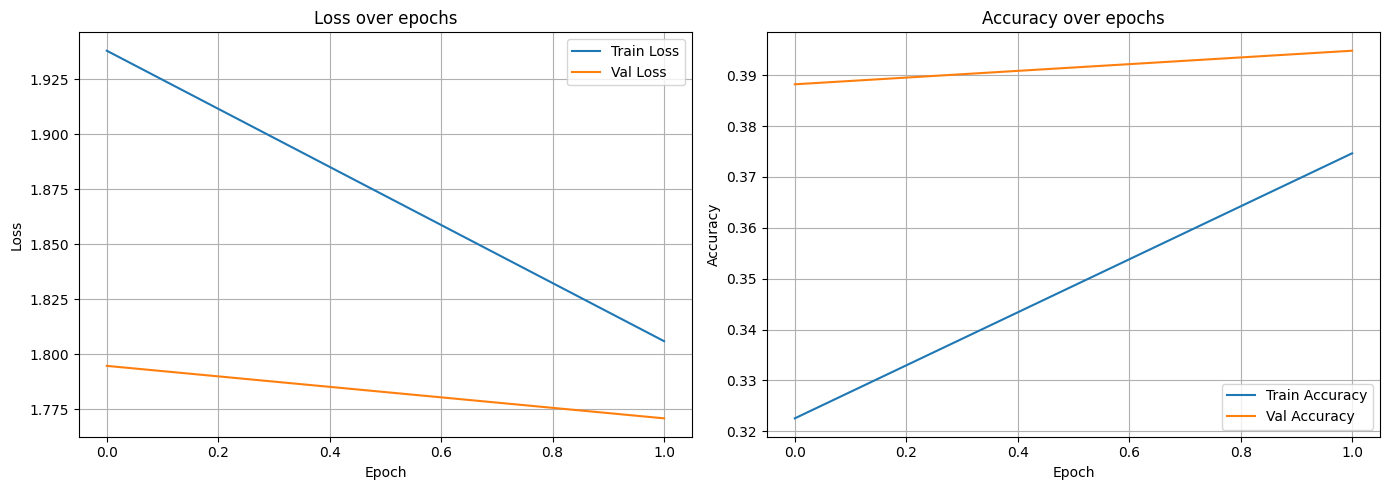

Epoch 2/10: Train Loss: 1.8059, Train Acc: 0.3746 | Val Loss: 1.7708, Val Acc: 0.3948


Training 3/10:   6%|▌         | 22/391 [00:08<02:30,  2.45it/s]


KeyboardInterrupt: 

In [137]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_pretrained.parameters()),
    lr=LEARNING_RATE
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

wandb_config = {
    'project': 'cifar10-transfer-learning',
    'run_name': 'resnet18-feature-extraction',
    'architecture': 'resnet18',
    'pretrained': True,
    'strategy': 'feature_extraction',
    'dataset': 'CIFAR-10',
    'epochs': NUM_EPOCHS,
    'batch_size': 128,
    'learning_rate': LEARNING_RATE,
}

print("Обучаем только последний слой (Feature Extraction)...\n")

train_losses, val_losses, train_accs, val_accs = train(
    model=model_pretrained,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    scheduler=scheduler,
    use_wandb=True,
    wandb_config=wandb_config
)

print(f"\nFeature Extraction Results:")
print(f"Final Val Accuracy: {val_accs[-1]:.2%}")

## Попробуем зафайнтюнить? Давайте разморозим веса и дообучим!

**Задание 4**

Каким образом мы можем разморозить все слои у нашей исходной модели? В чём главная причина того, что полный fine-tune будет работать дольше?

In [140]:
# Размораживаем все слои

# YOUR CODE IS HERE...

# Используем меньший learning rate для fine-tuning
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

wandb_config = {
    'project': 'cifar10-transfer-learning',
    'run_name': 'resnet18-fine-tuning',
    'architecture': 'resnet18',
    'strategy': 'fine_tuning',
    'epochs': 10,
    'learning_rate': 0.0001,
}

print("Fine-tuning всей сети с маленьким learning rate...\n")

train_losses_ft, val_losses_ft, train_accs_ft, val_accs_ft = train(
    model=model_pretrained,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    device=device,
    scheduler=scheduler,
    use_wandb=True,
    wandb_config=wandb_config
)

print(f"\nFine-tuning Results:")
print(f"Final Val Accuracy: {val_accs_ft[-1]:.2%}")

Fine-tuning всей сети с маленьким learning rate...



KeyboardInterrupt: 

# Домашнее задание

## Задание: Сравнение архитектур на CIFAR-10

**Цель:** Сравнить разные архитектуры используя Transfer Learning и выбрать лучшую.

### Что нужно сделать:

Обучите **3 разные архитектуры** на CIFAR-10 используя Feature Extraction (замороженный backbone). Почему Feature Extraction — он будет быстрее :)

**Выберите 3-4 модельки из списка:**
- `resnet18` или `resnet34`
- `efficientnet_b0`
- `mobilenetv2_100`
- `convnext_tiny`
- `vit_tiny_patch16_224`

### Шаги:

1. Загрузите предобученную модель из timm
2. Заморозьте все слои кроме последнего
3. Обучите 10 epochs
4. Логируйте в WandB

### Что сравнить:

1. Финальная Val Accuracy
2. Количество параметров модели
3. Скорость обучения (время на эпоху)

### Формат сдачи:

Короткий отчёт (3-5 предложений):
- Какая модель показала лучший результат?
- Какая самая быстрая?
- Какую бы вы выбрали для production и почему?

Приложите ссылку на WandB проект.

**Время выполнения:** ~30-40 минут на Colab (с GPU)